## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp
!pip install tensorflow

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    plt.style.use('dark_background')
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset =  nlp.load_dataset('emotion')

Using custom data configuration default


In [4]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [5]:
def get_tweet(data):
  tweets = [x['text']for x in data]
  labels = [x['label']for x in data]
  return tweets, labels

In [6]:
tweets,labels = get_tweet(train)

In [7]:
for x in range(20):
  print(tweets[x],'['+labels[x]+']')

i didnt feel humiliated [sadness]
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake [sadness]
im grabbing a minute to post i feel greedy wrong [anger]
i am ever feeling nostalgic about the fireplace i will know that it is still on the property [love]
i am feeling grouchy [anger]
ive been feeling a little burdened lately wasnt sure why that was [sadness]
ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny [surprise]
i feel as confused about life as a teenager or as jaded as a year old man [fear]
i have been with petronas for years i feel that petronas has performed well and made a huge profit [joy]
i feel romantic too [love]
i feel like i have to make the suffering i m seeing mean something [sadness]
i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter [joy]
i think it s the easiest time of year to feel 

## Task 4: Tokenizer

1. Tokenizing the tweets

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
tokenizer = Tokenizer(num_words=10000, oov_token ='<UNK>')
tokenizer.fit_on_texts(tweets)

In [10]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [11]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

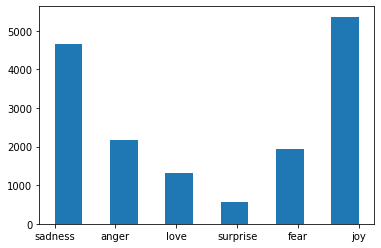

In [12]:
plt.hist(labels,bins =11)
plt.show()

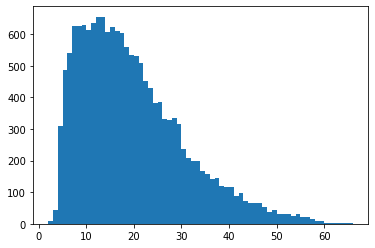

In [13]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [14]:
maxlen = 50

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_sequences(tokenizer,tweets):
  sequence = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequence, truncating = 'post', padding = 'post', maxlen = maxlen)
  return padded

In [17]:
padded_train_seq = get_sequences(tokenizer,tweets)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [18]:
classes = set(labels)

In [19]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [20]:
class_to_index

{'surprise': 0, 'anger': 1, 'love': 2, 'fear': 3, 'sadness': 4, 'joy': 5}

In [21]:
names_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [22]:
train_labels = names_to_ids(labels)

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [23]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [25]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer,val_tweets)
val_labels = names_to_ids(val_labels)

In [26]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq,val_labels),
    epochs = 20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 28s 43ms/step - loss: 1.2639 - accuracy: 0.5082 - val_loss: 0.7541 - val_accuracy: 0.7295
Epoch 2/20
500/500 [==============================] - 18s 36ms/step - loss: 0.5343 - accuracy: 0.8183 - val_loss: 0.5485 - val_accuracy: 0.8100
Epoch 3/20
500/500 [==============================] - 22s 43ms/step - loss: 0.3167 - accuracy: 0.8949 - val_loss: 0.4645 - val_accuracy: 0.8515
Epoch 4/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2094 - accuracy: 0.9359 - val_loss: 0.4058 - val_accuracy: 0.8820
Epoch 5/20
500/500 [==============================] - 20s 39ms/step - loss: 0.1603 - accuracy: 0.9511 - val_loss: 0.3800 - val_accuracy: 0.8890
Epoch 6/20
500/500 [==============================] - 19s 38ms/step - loss: 0.1317 - accuracy: 0.9603 - val_loss: 0.3737 - val_accuracy: 0.8930
Epoch 7/20
500/500 [==============================] - 20s 39ms/step - loss: 0.0999 - accuracy: 0.9698 - val_loss: 0.3815 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

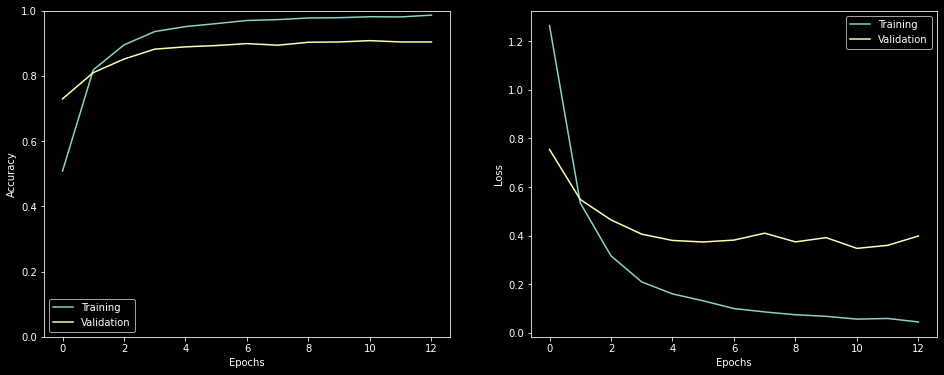

In [27]:
show_history(h)

In [28]:
model.save("emotional_model")

import pickle
with open('tokenizer.pickle','wb') as handle:
  pickle.dump(tokenizer,handle,protocol = pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle','wb') as ecn_file:
  pickle.dump(index_to_class,ecn_file,protocol = pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: emotional_model\assets


INFO:tensorflow:Assets written to: emotional_model\assets


In [29]:
test_sentences = ['Today is a wonderful day','My friend betray me!','i made that make me feel dumb and dumber','Tomorrow is exam','i feel soo lonely']
test_label = ['joy','anger','sadness','fear','sadness']
test_sequ = get_sequences(tokenizer,test_sentences)
test_label = names_to_ids(test_label)

for i in range (5):
  print('Sequence:',test_sentences[i])
  print('Emotion:',index_to_class[test_label[i]])

  p = model.predict(np.expand_dims(test_sequ[i],axis=0))[0]
  pred_class = index_to_class[np.argmax(p).astype('uint8')]

  print('Predicted Emotion:', pred_class,'\n')

Sequence: Today is a wonderful day
Emotion: joy
Predicted Emotion: joy 

Sequence: My friend betray me!
Emotion: anger
Predicted Emotion: anger 

Sequence: i made that make me feel dumb and dumber
Emotion: sadness
Predicted Emotion: sadness 

Sequence: Tomorrow is exam
Emotion: fear
Predicted Emotion: fear 

Sequence: i feel soo lonely
Emotion: sadness
Predicted Emotion: sadness 

